In [1]:
import pickle

from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import sys, os
sys.path.append(os.path.abspath("../../src"))
from visualisation import confusion

In [2]:
DATA_PATH = "../../datasets/bbc/tfidf/"
df = pd.read_csv('../../datasets/bbc/contents.csv', dtype={'label': 'category'})

with open(DATA_PATH+'features_train.pickle', 'rb') as data:
    features_train = pickle.load(data)

with open(DATA_PATH+'labels_train.pickle', 'rb') as data:
    labels_train = pickle.load(data)

with open(DATA_PATH+'features_test.pickle', 'rb') as data:
    features_test = pickle.load(data)

with open(DATA_PATH+'labels_test.pickle', 'rb') as data:
    labels_test = pickle.load(data)

In [3]:
print(len(features_train), len(features_test))

1891 334


# Default parameters

In [4]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9341317365269461

In [31]:
pprint(base_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


# Random Search

In [17]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(20, 100, num = 9)]
max_depth.append(None)
min_samples_split = [2, 4, 6, 8, 10, 12, 14]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid, compact=True)

{'bootstrap': [True, False],
 'max_depth': [20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8],
 'min_samples_split': [2, 4, 6, 8, 10, 12, 14],
 'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,
                  1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]}


In [18]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=100,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 30, 40, 50, 60, 70,
                                                      80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700, 800, 900,
                                                         1000, 1100, 1200, 1300,
                                                         1400, 1500, 1600, 1700,
                                                  

In [19]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9439396607383929


In [21]:
best_rfc = random_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       n_estimators=1200, random_state=8)

In [11]:
# Gridsearch around the best found by RandomSearch
# skipped

# Fit best model

In [22]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       n_estimators=1200, random_state=8)

# Performance analysis

In [33]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
1.0


In [5]:
rfc_pred = best_rfc.predict(features_test)

In [6]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.9341317365269461


In [7]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        76
           1       0.98      0.93      0.96        58
           2       0.93      0.89      0.91        63
           3       0.97      0.96      0.97        77
           4       0.93      0.93      0.93        60

    accuracy                           0.93       334
   macro avg       0.94      0.93      0.93       334
weighted avg       0.94      0.93      0.93       334



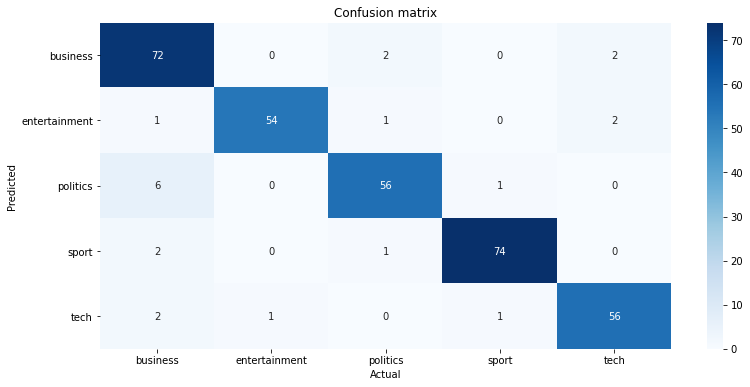

In [8]:
confusion(df, rfc_pred, labels_test)

# Sauvegardes

In [70]:
with open('../../models/bbc/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)

In [4]:
with open('../../models/bbc/best_rfc.pickle', 'rb') as f:
    best_rfc = pickle.load(f)

In [ ]:
df = pd.read_csv("../../models/bbc/models_score.csv")

In [77]:
row = [
    'Random Forest',
    accuracy_score(labels_train, best_rfc.predict(features_train)),
    accuracy_score(labels_test, best_rfc.predict(features_test))
    ]

In [78]:
# if first model
#df = pd.DataFrame([row], columns=['Model', 'Train accuracy', 'Test accuracy'])

In [63]:
df.loc[len(df)] = row

In [80]:
df.to_csv('../../models/bbc/models_score.csv', index=False)